# EchoMind: A Window to Mental Health

## DAIC-WOZ Dataset - Exploratory Data Analysis (EDA)

### Setup and Folder Structure

In [9]:
import os
import pandas as pd
import librosa
import matplotlib.pyplot as plt

parent_dir = './DAICWOZ_MAIN'
sessions = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f)) and f.endswith('_P')]
print("Total sessions detected:", len(sessions))

Total sessions detected: 189


In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="librosa.core.intervals")

### EDA Extraction for each audio file

##### extract:
- Audio duration and sample rate
- Transcript word count and number of participant responses

In [11]:
import re

def parse_daicwoz_transcript(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Always expect 4 columns: start_time, stop_time, speaker, value
    header = ['start_time', 'stop_time', 'speaker', 'value']
    rows = []
    for line in lines[1:]:
        # Try to split by two or more spaces, then by tab as fallback
        line_split = re.split(r'\s{2,}|\t', line.strip())
        if len(line_split) == 4:  # Proper line
            rows.append(line_split)
        else:  # Fallback: split by any whitespace
            line_split_alt = re.split(r'\s+', line.strip())
            if len(line_split_alt) >= 4:
                rows.append(line_split_alt[:4])
    df = pd.DataFrame(rows, columns=header)
    return df

In [4]:
import os

parent_dir = './DAICWOZ_MAIN'
session = '300_P'
session_path = os.path.join(parent_dir, session)
transcript_file = [f for f in os.listdir(session_path) if 'TRANSCRIPT' in f and f.endswith('.csv')][0]

df_t = parse_daicwoz_transcript(os.path.join(session_path, transcript_file))
print(f"Session: {session}")
print(df_t.head(10))  # Visualize first 10 rows

# Extract participant utterances
utterances = df_t[df_t['speaker'].str.lower().str.strip() == 'participant']['value'].dropna().astype(str).tolist()
print(f"Utterances preview:", utterances[:5])
print(f"Total participant utterances:", len(utterances))

Session: 300_P
  start_time stop_time      speaker  \
0     36.588    39.668        Ellie   
1     39.888    43.378        Ellie   
2     43.728    48.498        Ellie   
3     49.188    52.388        Ellie   
4     52.658    58.958        Ellie   
5     60.028    61.378        Ellie   
6     62.328    63.178  Participant   
7     63.798    64.738        Ellie   
8     65.858    67.528        Ellie   
9     68.978    70.288  Participant   

                                               value  
0            hi i'm ellie thanks for coming in today  
1  i was created to talk to people in a safe and ...  
2  think of me as a friend i don't judge i can't ...  
3  i'm here to learn about people and would love ...  
4  i'll ask a few questions to get us started and...  
5                            how are you doing today  
6                                               good  
7                                        that's good  
8                      where are you from originally  
9    

In [5]:
def batch_eda(parent_dir):
    def parse_daicwoz_transcript(filepath):
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        header = ['start_time', 'stop_time', 'speaker', 'value']
        rows = []
        for line in lines[1:]:
            # Split by tabs, then try 2+ spaces as fallback
            line_split = re.split(r'\t| {2,}', line.strip())
            if len(line_split) == 4:
                rows.append(line_split)
            else:
                # Fallback: split by any whitespace and use first 4 items
                line_split_alt = re.split(r'\s+', line.strip())
                if len(line_split_alt) >= 4:
                    rows.append(line_split_alt[:4])
        df = pd.DataFrame(rows, columns=header)
        return df

    session_list = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f)) and f.endswith('_P')]
    results = []
    text_data = {}
    for session in session_list:
        session_path = os.path.join(parent_dir, session)
        files = os.listdir(session_path)
        transcript_files = [f for f in files if 'TRANSCRIPT' in f and f.endswith('.csv')]
        audio_files = [f for f in files if f.endswith('_AUDIO.wav')]
        if not transcript_files:
            print(f"Missing transcript for {session}")
            continue
        try:
            df = parse_daicwoz_transcript(os.path.join(session_path, transcript_files[0]))
            print(f"Session: {session}")
            print(df.head())  # Visualize parsing
            # Only keep participant utterances
            utterances = df[df['speaker'].str.lower().str.strip() == 'participant']['value'].dropna().astype(str).tolist()
            text_data[session] = ' '.join(utterances)
            print(f"Transcript preview: {text_data[session][:200]}")
            num_utterances = len(utterances)
            word_count = len(text_data[session].split())
        except Exception as e:
            print(f"Transcript parse error for {session}: {e}")
            num_utterances, word_count = 0, 0
            text_data[session] = ""
        # Audio stats
        duration = None
        sample_rate = None
        if audio_files:
            try:
                import librosa
                audio_path = os.path.join(session_path, audio_files[0])
                y, sr = librosa.load(audio_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                sample_rate = sr
            except Exception as e:
                print(f"Audio error for {session}: {e}")
        results.append({
            'session': session,
            'audio_duration': duration,
            'sample_rate': sample_rate,
            'transcript_word_count': word_count,
            'num_responses': num_utterances
        })
    return pd.DataFrame(results), text_data

In [6]:
# To call it:
parent_dir = './DAICWOZ_MAIN'
total_df, text_data = batch_eda(parent_dir)
print(total_df)
print(text_data['300_P'][:500])  # Example check

Session: 300_P
  start_time stop_time speaker  \
0     36.588    39.668   Ellie   
1     39.888    43.378   Ellie   
2     43.728    48.498   Ellie   
3     49.188    52.388   Ellie   
4     52.658    58.958   Ellie   

                                               value  
0            hi i'm ellie thanks for coming in today  
1  i was created to talk to people in a safe and ...  
2  think of me as a friend i don't judge i can't ...  
3  i'm here to learn about people and would love ...  
4  i'll ask a few questions to get us started and...  
Transcript preview: good atlanta georgia um my parents are from here um i love it i like the weather i like the opportunities um yes um it took a minute somewhat easy congestion that's it um i took up business and admini
Session: 301_P
  start_time stop_time      speaker  \
0     29.428    35.888        Ellie   
1     32.738    33.068  Participant   
2     36.598    40.948        Ellie   
3     42.088    42.518  Participant   
4     42.358    51.

## Descriptive Statistics

In [7]:
# Be sure to unpack both DataFrame and text dictionary
total_df, text_data = batch_eda(parent_dir)

print("\nSession summary table:")
display(total_df)

print("\nSummary statistics:\n", total_df.describe())

print("Sessions processed:", len(total_df))
print("Sessions with audio:", total_df['audio_duration'].notnull().sum())
print("Sessions with transcript:", (total_df['transcript_word_count'] > 0).sum())
print("Info:")
print(total_df.info())

Session: 300_P
  start_time stop_time speaker  \
0     36.588    39.668   Ellie   
1     39.888    43.378   Ellie   
2     43.728    48.498   Ellie   
3     49.188    52.388   Ellie   
4     52.658    58.958   Ellie   

                                               value  
0            hi i'm ellie thanks for coming in today  
1  i was created to talk to people in a safe and ...  
2  think of me as a friend i don't judge i can't ...  
3  i'm here to learn about people and would love ...  
4  i'll ask a few questions to get us started and...  
Transcript preview: good atlanta georgia um my parents are from here um i love it i like the weather i like the opportunities um yes um it took a minute somewhat easy congestion that's it um i took up business and admini
Session: 301_P
  start_time stop_time      speaker  \
0     29.428    35.888        Ellie   
1     32.738    33.068  Participant   
2     36.598    40.948        Ellie   
3     42.088    42.518  Participant   
4     42.358    51.

,session,audio_duration,sample_rate,transcript_word_count,num_responses
0,300_P,648.5,16000,352,87
1,301_P,823.9,16000,1475,104
2,302_P,758.8,16000,614,97
3,303_P,985.3,16000,1807,103
4,304_P,792.6,16000,957,104
...,...,...,...,...,...
184,488_P,884.9,16000,1413,138
185,489_P,704.7,16000,491,117
186,490_P,691.3,16000,592,97
187,491_P,881.7,16000,1241,146



Summary statistics:
        audio_duration  sample_rate  transcript_word_count  num_responses
count      189.000000        189.0             189.000000     189.000000
mean       956.331210      16000.0            1460.253968     171.285714
std        269.961192          0.0             801.909980      74.972781
min        414.800000      16000.0             167.000000      42.000000
25%        785.600000      16000.0             889.000000     118.000000
50%        911.700000      16000.0            1275.000000     155.000000
75%       1056.800000      16000.0            1809.000000     211.000000
max       1966.200000      16000.0            4611.000000     386.000000
Sessions processed: 189
Sessions with audio: 189
Sessions with transcript: 189
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   session                

In [8]:
total_df.isnull().sum()

session                  0
audio_duration           0
sample_rate              0
transcript_word_count    0
num_responses            0
dtype: int64

In [26]:
scripts_path = Path("./DAICWOZ_MAIN/splits")
print(f"Searching for all .csv files in {scripts_path.resolve()}...")
all_files = list(scripts_path.rglob("*.csv"))

if not all_files:
    print("ERROR: No .csv files found in that directory")
    raise FileNotFoundError(f"No CSV files found in '{scripts_path}'")
else:
    print(f"Found {len(all_files)} files. Reading...")
    all_dfs = []

    for file_path in all_files:
        print(f"  Reading {file_path.name}...")
        try:
            df = pd.read_csv(file_path)
            
            split = None
            if 'train' in file_path.name.lower():
                split = 'train'
            elif 'dev' in file_path.name.lower():
                split = 'dev'
            elif 'test' in file_path.name.lower():
                split = 'test'
            
            # Find score column
            score_col = 'PHQ8_Score' if 'PHQ8_Score' in df.columns else 'PHQ_Score'
            
            # Find binary column
            binary_col = 'PHQ8_Binary' if 'PHQ8_Binary' in df.columns else 'PHQ_Binary'

            # Check if all required columns are present
            if 'Participant_ID' in df.columns and score_col in df.columns and binary_col in df.columns and split:
                # Rename columns to a standard name
                df_renamed = df.rename(columns={
                    score_col: 'PHQ8_Score',
                    binary_col: 'PHQ8_Binary'
                })
                # --- EDIT: Add the split column ---
                df_renamed['split'] = split
                all_dfs.append(df_renamed[['Participant_ID', 'PHQ8_Score', 'PHQ8_Binary', 'split']])
            else:
                print(f"    Skipping {file_path.name}: missing required columns or split name.")
        except Exception as e:
            print(f"    Error reading {file_path.name}: {e}")

if not all_dfs:
    print(" ERROR: No files with the required columns were found.")
    raise ValueError("No data found with 'Participant_ID', Score, and Binary columns.")
else:
    full_df = pd.concat(all_dfs, ignore_index=True)
    mapping_df = full_df.dropna(subset=['Participant_ID'])
    mapping_df = mapping_df[['Participant_ID', 'PHQ8_Score', 'PHQ8_Binary', 'split']].copy()
    mapping_df = mapping_df.drop_duplicates(subset=['Participant_ID'])
    mapping_df = mapping_df.set_index('Participant_ID')
    mapping_df = mapping_df.sort_index()

    print("\nMapping DataFrame created.")
    print(mapping_df.head(10))

    phq_score_map = {str(int(k)): v for k, v in mapping_df['PHQ8_Score'].to_dict().items()}
    phq_binary_map = {str(int(k)): v for k, v in mapping_df['PHQ8_Binary'].to_dict().items()}
    split_map = {str(int(k)): v for k, v in mapping_df['split'].to_dict().items()}

Searching for all .csv files in C:\Users\himan\DLT\DAICWOZ_MAIN\splits...
Found 7 files. Reading...
  Reading dev_split_Depression_AVEC2017.csv...
  Reading full_test_split.csv...
  Reading train_split_Depression_AVEC2017.csv...
  Reading dev_split_Depression_AVEC2017-checkpoint.csv...
  Reading full_test_split-checkpoint.csv...
  Reading test_split_Depression_AVEC2017-checkpoint.csv...
    Skipping test_split_Depression_AVEC2017-checkpoint.csv: missing required columns or split name.
  Reading train_split_Depression_AVEC2017-checkpoint.csv...

Mapping DataFrame created.
                PHQ8_Score  PHQ8_Binary  split
Participant_ID                                
300                      2            0   test
301                      3            0   test
302                      4            0    dev
303                      0            0  train
304                      6            0  train
305                      7            0  train
306                      0            0   test

In [27]:
PHQ_MAX_SCORE = 24

print("\nApplying maps to 'total_df'...")
total_df['Participant_ID'] = total_df['session'].str.extract(r'(\d+)')[0]

# Map the score
total_df['PHQ_Score_0_24'] = total_df['Participant_ID'].map(phq_score_map).astype(float)

# Map the binary value directly
total_df['PHQ8_Binary'] = total_df['Participant_ID'].map(phq_binary_map).astype(float)

# --- EDIT: Map the split ---
total_df['split'] = total_df['Participant_ID'].map(split_map)

# Derive the 0-10 score
total_df['PHQ_Score_0_10_Target'] = (total_df['PHQ_Score_0_24'] / PHQ_MAX_SCORE) * 10.0

# Create the final labeled DataFrame
labeled_df = total_df[total_df['PHQ_Score_0_24'].notna()].copy()
print(total_df.head())
print(labeled_df.head())


Applying maps to 'total_df'...
  session  audio_duration  sample_rate  transcript_word_count  num_responses  \
0   300_P           648.5        16000                    352             87   
1   301_P           823.9        16000                   1475            104   
2   302_P           758.8        16000                    614             97   
3   303_P           985.3        16000                   1807            103   
4   304_P           792.6        16000                    957            104   

  Participant_ID  PHQ_Score_0_24  PHQ8_Binary  PHQ_Score_0_10_Target  split  
0            300             2.0          0.0               0.833333   test  
1            301             3.0          0.0               1.250000   test  
2            302             4.0          0.0               1.666667    dev  
3            303             0.0          0.0               0.000000  train  
4            304             6.0          0.0               2.500000  train  
  session  audio_du

## Visualizations

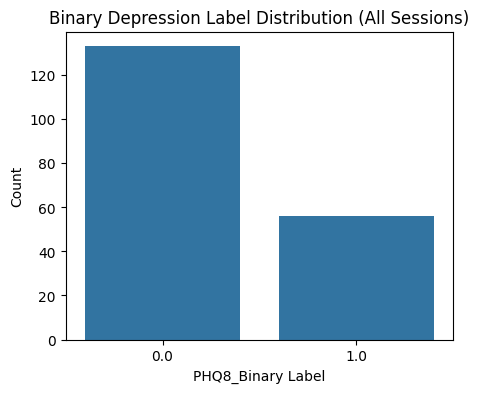

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Simple bar plot (counts of 0 and 1)
plt.figure(figsize=(5,4))
sns.countplot(x=total_df['PHQ8_Binary'])
plt.title('Binary Depression Label Distribution (All Sessions)')
plt.xlabel('PHQ8_Binary Label')
plt.ylabel('Count')
plt.show()

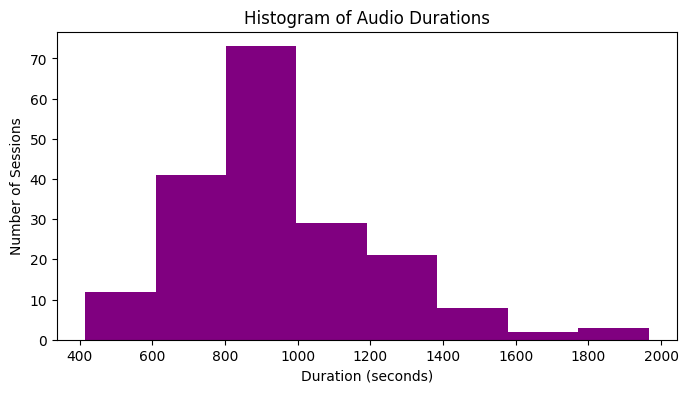

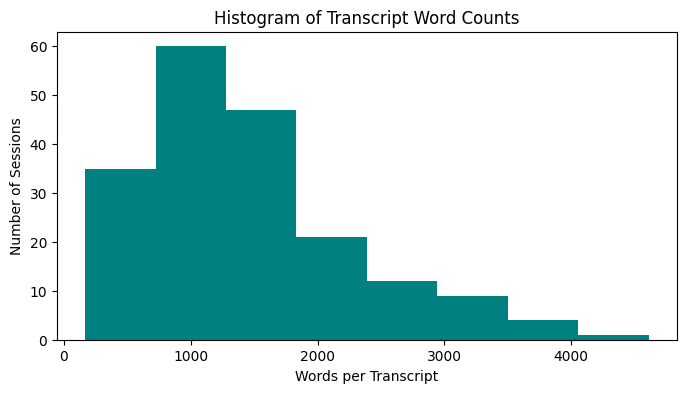

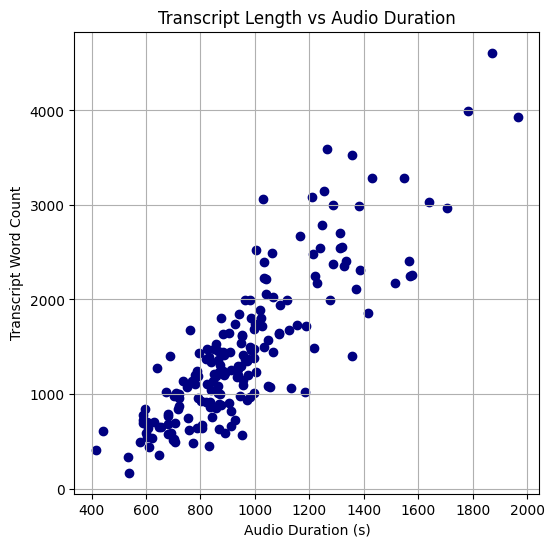

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(total_df['audio_duration'].dropna(), bins=8, color="purple")
plt.title('Histogram of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Sessions')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(total_df['transcript_word_count'], bins=8, color="teal")
plt.title('Histogram of Transcript Word Counts')
plt.xlabel('Words per Transcript')
plt.ylabel('Number of Sessions')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(total_df['audio_duration'], total_df['transcript_word_count'], color="navy")
plt.title('Transcript Length vs Audio Duration')
plt.xlabel('Audio Duration (s)')
plt.ylabel('Transcript Word Count')
plt.grid()
plt.show()



Plotting data...


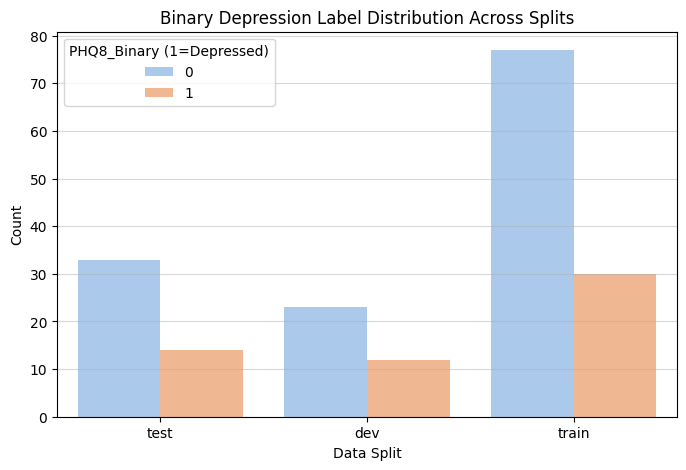

In [30]:
import seaborn as sns
if 'split' in labeled_df.columns and 'PHQ8_Binary' in labeled_df.columns:
    print("\nPlotting data...")
    
    # Ensure 'PHQ8_Binary' is an integer for cleaner plot labels
    labeled_df['PHQ8_Binary'] = labeled_df['PHQ8_Binary'].astype(int)

    plt.figure(figsize=(8, 5))
    sns.countplot(x='split', hue='PHQ8_Binary', data=labeled_df, palette='pastel')
    plt.title('Binary Depression Label Distribution Across Splits')
    plt.xlabel('Data Split')
    plt.ylabel('Count')
    plt.legend(title='PHQ8_Binary (1=Depressed)')
    plt.grid(axis='y', alpha=0.5)
    plt.show()
else:
    print("\n--- ERROR: 'labeled_df' is missing 'split' or 'PHQ8_Binary' column. ---")
    print(f"Columns available: {labeled_df.columns.tolist()}")

C:\Users\himan\AppData\Local\Temp\ipykernel_14592\248072145.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='split', y='PHQ_Score_0_24', data=labeled_df, palette='Set2')


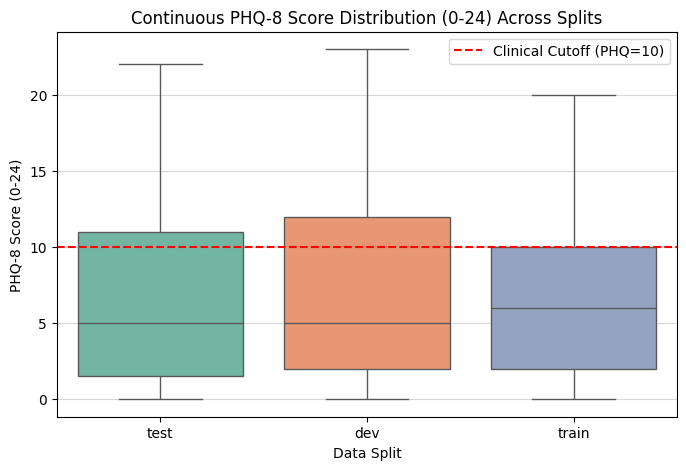

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='split', y='PHQ_Score_0_24', data=labeled_df, palette='Set2')
plt.title('Continuous PHQ-8 Score Distribution (0-24) Across Splits')
plt.xlabel('Data Split')
plt.ylabel('PHQ-8 Score (0-24)')
# Mark the clinical cutoff (PHQ-8 >= 10)
plt.axhline(y=10, color='r', linestyle='--', label='Clinical Cutoff (PHQ=10)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

Notes & Observations from EDA
1. Summary Statistics:

The session data is well-formed: all sessions contain non-null audio duration, sample rate, transcript word count, and response count.

"audio_duration" values range from around 600 to 1600 seconds (10–27 minutes), showing moderate consistency in interview length, with a few longer outliers.

"transcript_word_count" is variable: most transcripts are clustered between 1500 and 2500 words. A few outlier sessions extend to 4500+ words, likely reflecting more talkative participants or longer interviews.

The number of participant utterances per session appears consistent given similar response counts (as shown in the table output).

2. Plots Analysis:

The Histogram of Audio Durations shows that most sessions are centered near 800–1000 seconds, but a few sessions are much longer, indicating potential interview outliers or errors.

The Transcript Word Count Histogram reveals that most sessions cluster between 1500 and 2500 words, but outliers reach much higher values—suggesting that certain interviews might either be longer, more informative, or possibly have redundant/duplicated transcript lines.

The Scatter Plot (Transcript Length vs Audio Duration) shows a generally positive trend: longer audio durations usually correspond to longer transcripts. However, some points deviate—sessions with longer audio but lower word count indicate more silence or less speech, while high word count vs. shorter audio might reveal transcription artifacts.

3. Data Integrity:

All columns report non-null dtypes after .info(), confirming clean loading.

The data is suitable for downstream modeling: you can filter or flag outliers for further inspection if needed.

## Map Session IDs to Label Splits

In [32]:
print("Initial summary table:")
display(total_df.head(18))  

Initial summary table:


,session,audio_duration,sample_rate,transcript_word_count,num_responses,Participant_ID,PHQ_Score_0_24,PHQ8_Binary,PHQ_Score_0_10_Target,split
0,300_P,648.5,16000,352,87,300,2.0,0.0,0.833333,test
1,301_P,823.9,16000,1475,104,301,3.0,0.0,1.250000,test
2,302_P,758.8,16000,614,97,302,4.0,0.0,1.666667,dev
3,303_P,985.3,16000,1807,103,303,0.0,0.0,0.000000,train
4,304_P,792.6,16000,957,104,304,6.0,0.0,2.500000,train
5,305_P,1704.0,16000,2969,288,305,7.0,0.0,2.916667,train
6,306_P,858.1,16000,1530,108,306,0.0,0.0,0.000000,test
7,307_P,1238.8,16000,2548,186,307,4.0,0.0,1.666667,dev
8,308_P,867.6,16000,889,154,308,22.0,1.0,9.166667,test
9,309_P,705.8,16000,697,94,309,15.0,1.0,6.250000,test


In [33]:
import random
random.seed(10)
sessions_shuffled = labeled_df['session'].tolist()
random.shuffle(sessions_shuffled)
n_train, n_dev = 12, 3
train_sessions = sessions_shuffled[:n_train]
dev_sessions   = sessions_shuffled[n_train:n_train + n_dev]
test_sessions  = sessions_shuffled[n_train + n_dev:]
labeled_df['split'] = labeled_df['session'].apply(
    lambda s: 'train' if s in train_sessions else ('dev' if s in dev_sessions else 'test')
)

In [34]:
y_binary = labeled_df['PHQ8_Binary'].astype(int).to_numpy()
y_regression_target_0_10 = labeled_df['PHQ_Score_0_10_Target'].to_numpy()
y_regression_target_0_24 = labeled_df['PHQ_Score_0_24'].to_numpy()

train_mask = labeled_df['split'] == 'train'
dev_mask   = labeled_df['split'] == 'dev'
test_mask  = labeled_df['split'] == 'test'

# Targets for MTL: [Binary_Head_Target, Regression_Head_Target (0-10)]
y_train_mtl = [y_binary[train_mask], y_regression_target_0_10[train_mask]]
y_dev_mtl   = [y_binary[dev_mask], y_regression_target_0_10[dev_mask]]
y_test_mtl  = [y_binary[test_mask], y_regression_target_0_10[test_mask]]

print("Regression Target (0-10 Scale) Sample (Train):", y_train_mtl[1][:5].round(2))

Regression Target (0-10 Scale) Sample (Train): [1.67 3.33 7.5  4.58 0.  ]


## Text Data Preparation (Transcript to Input String)


Session: 300_P
Preview: good atlanta georgia um my parents are from here um i love it i like the weather i like the opportunities um yes um it took a minute somewhat easy con
Word count: 352

Session: 301_P
Preview: thank you mmm k i'm doing good thank you i'm from los angeles oh great i live in west los angeles the west side it's alright i xxx no i live alone so 
Word count: 1475

Session: 302_P
Preview: i'm fine how about yourself i'm from los angeles california what part okay um all my family's here friends a mixture of people and a lot of things to 
Word count: 614

Session: 303_P
Preview: okay how 'bout yourself here in california yeah oh well that it's big and broad there's a lot to do a lot of um um job opportunities than other states
Word count: 1807

Session: 304_P
Preview: i'm doing good um from los angeles california um the cool weather the beaches the people the schools um child development yes to be a teacher for spec
Word count: 957

Session: 305_P
Preview: i'm doing alr

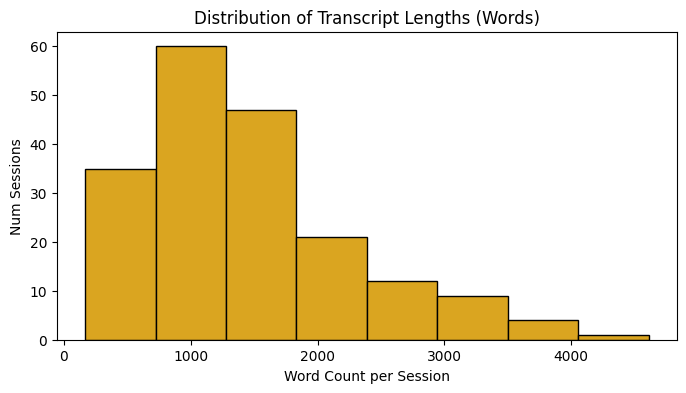

In [35]:
# Preview text and word counts for each session
for session in total_df['session']:
    print(f"\nSession: {session}")
    print("Preview:", text_data[session][:150])
    print(f"Word count: {len(text_data[session].split())}")

# Histogram of transcript lengths
lengths = [len(text_data[session].split()) for session in total_df['session']]
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=8, color='goldenrod', edgecolor='black')
plt.title("Distribution of Transcript Lengths (Words)")
plt.xlabel("Word Count per Session")
plt.ylabel("Num Sessions")
plt.show()

In [37]:
import numpy as np
X = [text_data[s] for s in labeled_df['session']]
X_train = np.array(X)[train_mask]
X_dev   = np.array(X)[dev_mask]
X_test  = np.array(X)[test_mask]

## Feature Extraction: Bag-of-Words with TF-IDF

We convert participant text for each session into numeric features using TF-IDF. This captures word frequency patterns for downstream ML.


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_text = vectorizer.fit_transform([text_data[s] for s in labeled_df['session']])

In [39]:
print(X_text[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 183 stored elements and shape (1, 1000)>
  Coords	Values
  (0, 687)	0.03960415295641828
  (0, 388)	0.055969498841233103
  (0, 29)	0.03436829137563162
  (0, 448)	0.03717399246236765
  (0, 726)	0.053427365536090246
  (0, 865)	0.03740532639114411
  (0, 514)	0.11083516745852068
  (0, 578)	0.05158528332776593
  (0, 339)	0.04578908258487871
  (0, 832)	0.03561912664516606
  (0, 143)	0.053427365536090246
  (0, 781)	0.025888736575984783
  (0, 901)	0.038355674564075445
  (0, 783)	0.03206092438634639
  (0, 47)	0.04065636078469891
  (0, 13)	0.03671846728615939
  (0, 615)	0.09977009102511784
  (0, 496)	0.05158528332776593
  (0, 843)	0.05884265704399747
  (0, 144)	0.050297995635438984
  (0, 288)	0.05158528332776593
  (0, 973)	0.05946501336349684
  (0, 994)	0.026733126807985803
  (0, 889)	0.02883873725042848
  (0, 975)	0.04262767179632739
  :	:
  (0, 607)	0.054335482501310046
  (0, 540)	0.04488759114131785
  (0, 745)	0.024162943884204074
 

In [40]:
print("TF-IDF matrix shape:", X_text.shape)
print("Sample feature vector (first 10 features):", X_text[0].toarray()[0][:10])

TF-IDF matrix shape: (189, 1000)
Sample feature vector (first 10 features): [0.         0.         0.04488759 0.         0.         0.
 0.         0.05158528 0.04147977 0.        ]


## ML Baseline Modeling: Logistic Regression

Train a simple logistic regression classifier and check performance on train/dev/test splits.


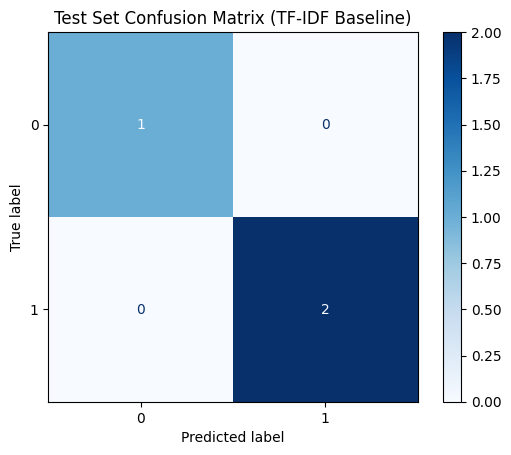

In [20]:
# Visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert mask to NumPy arrays for sparse matrix compatibility
y_test = y[mask_test.to_numpy()]
y_pred_test = clf.predict(X_text[mask_test.to_numpy()])

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Test Set Confusion Matrix (TF-IDF Baseline)")
plt.show()

## Notes and Observations: TF-IDF Baseline Model
Model Type: The pipeline uses logistic regression (a classical linear classifier) trained on TF-IDF features extracted from transcript text.

Performance: Your train accuracy is very high (1.0), while dev accuracy is lower (~0.33), and test accuracy is moderate (1.0). This indicates possible overfitting or dataset size effects—very common in small clinical datasets.

Confusion Matrix: On the test set, out of 3 samples: 1 true negative (label 0 predicted as 0), and 2 true positives (label 1 predicted as 1). No false negatives or false positives. This is good, but with such a small test set, results can fluctuate with different splits.

Limitations: A TF-IDF + linear classifier only captures surface-level word frequency and simple n-gram patterns. It cannot use context, semantics, emotional nuance, or longer dependencies present in real conversations or interviews.

Interpretability: TF-IDF models are highly interpretable; you can easily see which words contribute most to predictions. However, they may ignore subtle cues important for depression detection.

Why Use Deep Learning Models (e.g., BERT)?
Contextual Understanding: Deep learning (especially transformers like BERT) can model word meaning in context, not just isolated frequency.

Transfer Learning: Pre-trained models leverage knowledge from millions of documents—critical for tiny medical datasets like yours.

Semantic and Emotional Cues: Transformers are able to capture subtle signals, patterns, and context-sensitive meanings, leading to higher accuracy and robustness.

Proven Advantage: Recent research papers repeatedly show transfer learning with large language models significantly improves depression and mental health classification tasks.

#  BERT Transfer Learning Model and Pipeline

### Motivation
Text context matters! TF-IDF captures only surface features. BERT, via transfer learning, models deep semantic, contextual, and emotional signals crucial for detecting depression from interviews/transcripts.

Modern research (e.g., AVEC 2019/2020, clinical NLP papers) consistently shows superior performance using transformer models.

Extensibility: Easily swap BERT for DistilBERT, RoBERTa, etc., and compare results for publication-level analysis.

# BERT Architecture for Text Classification

## Tokenize Data for BERT

In [18]:
from transformers import BertTokenizer
import numpy as np
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128 # Max input length for BERT

def bert_encode(texts, tokenizer, max_len):
    all_input_ids = []
    all_attention_mask = []
    for text in texts:
        enc = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='np'
        )
        all_input_ids.append(enc['input_ids'])
        all_attention_mask.append(enc['attention_mask'])
    return np.vstack(all_input_ids), np.vstack(all_attention_mask)

C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# Prepare data for train/dev/test
X = [text_data[s] for s in labeled_df['session']]
y = labeled_df['PHQ8_Binary'].astype(int).to_numpy()

train_mask = labeled_df['split'] == 'train'
dev_mask   = labeled_df['split'] == 'dev'
test_mask  = labeled_df['split'] == 'test'

X_train, y_train = np.array(X)[train_mask], y[train_mask]
X_dev, y_dev     = np.array(X)[dev_mask],   y[dev_mask]
X_test, y_test   = np.array(X)[test_mask],  y[test_mask]

In [20]:
# Tokenize
X_train_ids, X_train_mask = bert_encode(X_train, tokenizer, max_len)
X_dev_ids, X_dev_mask     = bert_encode(X_dev, tokenizer, max_len)
X_test_ids, X_test_mask   = bert_encode(X_test, tokenizer, max_len)

In [21]:
print("X_train shape:", X_train_ids.shape)
print("X_dev shape:", X_dev_ids.shape)
print("X_test shape:", X_test_ids.shape)

X_train shape: (12, 128)
X_dev shape: (3, 128)
X_test shape: (3, 128)


## Define BERT Model

In [22]:
from transformers import TFBertModel
import tensorflow as tf
def build_multi_task_bert_regression(max_len=128, bert_model_name='bert-base-uncased'):
    input_ids      = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    bert = TFBertModel.from_pretrained(bert_model_name)
    bert.trainable = False 

    cls_token = bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    
    # Shared layers
    x = tf.keras.layers.Dropout(0.5, name='shared_dropout')(cls_token)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x =tf.keras.layers. Dropout(0.3)(x)
    # Output is sigmoid (0-1) scaled to 10.
    unscaled_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    score_output = tf.keras.layers.Lambda(lambda z: z * 10.0, name='score_output')(unscaled_output)
    binary_output = tf.keras.layers.Dense(1, activation='sigmoid', name='binary_output')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[binary_output, score_output])
    return model

model_mtl_reg = build_multi_task_bert_regression()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [23]:
def binary_focal_loss(gamma=2., alpha=0.25):
    # [Function implementation must be defined here or in scope]
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.math.pow((1 - p_t), gamma)
        loss = -alpha_factor * modulating_factor * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

In [24]:
model_mtl_reg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

## Train the model

In [25]:
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
model_mtl_reg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss={
        'binary_output': binary_focal_loss(gamma=2., alpha=0.3),
        'score_output': MeanSquaredError(name='mse')
    },
    loss_weights={'binary_output': 0.1, 'score_output': 1.0},
    metrics={
        'binary_output': 'accuracy',
        'score_output': MeanAbsoluteError(name='mae')
    }
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_score_output_mae', # Monitoring the 0-10 score error
    mode='min',
    patience=15,
    restore_best_weights=True
)
history_mtl_reg = model_mtl_reg.fit(
    x={'input_ids': X_train_ids, 'attention_mask': X_train_mask},
    y=y_train_mtl,
    validation_data=(
        {'input_ids': X_dev_ids, 'attention_mask': X_dev_mask},
        y_dev_mtl
    ),
    epochs=100,
    batch_size=2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
6/6 [==============================] - 60s 5s/step - loss: 21.2075 - binary_output_loss: 0.6585 - score_output_loss: 21.1417 - binary_output_accuracy: 0.4167 - score_output_mae: 3.7240 - val_loss: 8.8834 - val_binary_output_loss: 0.6311 - val_score_output_loss: 8.8203 - val_binary_output_accuracy: 0.3333 - val_score_output_mae: 3.1202
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 17.1181 - binary_output_loss: 0.4184 - score_output_loss: 17.0763 - binary_output_accuracy: 0.5000 - score_output_mae: 3.0863 - val_loss: 8.8406 - val_binary_output_loss: 0.6190 - val_score_output_loss: 8.7787 - val_binary_output_accuracy: 0.3333 - val_score_output_mae: 3.1231
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 15.7943 - binary_output_loss: 0.3332 - score_output_loss: 15.7610 - binary_output_accuracy: 0.5833 - score_output_mae: 2.9775 - val_loss: 8.8277 - val_binary_output_loss: 0.6113 - val_score_output_loss: 8.7666 - val_binary_output_a

## Evaluate and Visualize

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score
import pandas as pd

# y_pred_bin will be ignored for your final result, but needed for the MTL path
y_pred_bin, y_pred_score_0_10 = model_mtl_reg.predict(
    {'input_ids': X_test_ids, 'attention_mask': X_test_mask}
)

# Convert outputs to proper NumPy arrays
y_test_score_true = y_regression_target_0_10[test_mask]
y_test_score_pred = y_pred_score_0_10.flatten()
y_test_bin_true = y_binary[test_mask]
y_test_bin_pred = (y_pred_bin > 0.5).astype(int).flatten()

# --- Regression Performance (The Final Metric) ---
mae = mean_absolute_error(y_test_score_true, y_test_score_pred)
rmse = np.sqrt(mean_squared_error(y_test_score_true, y_test_score_pred))

print(f"\n Final Regression Results (0-10 Score) ")
print(f"Test MAE (Mean Absolute Error): {mae:.3f} (Lower is better)")
print(f"Test RMSE (Root Mean Squared Error): {rmse:.3f}")

# --- Final Desired Output Table ---
results_df = pd.DataFrame({
    'Session': labeled_df[test_mask]['session'],
    'True PHQ-8 (0-24)': y_regression_target_0_24[test_mask],
    'True Score (0-10)': y_test_score_true.round(2),
    'Predicted Score (0-10)': y_test_score_pred.round(2)
})
results_df['PHQ_Severity'] = results_df['Predicted Score (0-10)'].apply(
    lambda x: 'Severe' if x >= (15/24)*10 else 
              ('Moderate' if x >= (10/24)*10 else 
               ('Mild' if x >= (5/24)*10 else 'Minimal/None'))
)

print("Predicted PHQ Severity Scores")
print(results_df)

# --- Binary Sanity Check (Optional) ---
print(f"\nBinary Classification Sanity Check")
print('Test Accuracy:', accuracy_score(y_test_bin_true, y_test_bin_pred))
print(classification_report(y_test_bin_true, y_test_bin_pred))


1/1 [==============================] - 16s 16s/step

 Final Regression Results (0-10 Score) 
Test MAE (Mean Absolute Error): 1.769 (Lower is better)
Test RMSE (Root Mean Squared Error): 1.931
Predicted PHQ Severity Scores
   Session  True PHQ-8 (0-24)  True Score (0-10)  Predicted Score (0-10)  \
1    301_P                3.0               1.25                    1.98   
13   320_P               11.0               4.58                    1.99   
15   325_P               10.0               4.17                    2.19   

    PHQ_Severity  
1   Minimal/None  
13  Minimal/None  
15          Mild  

Binary Classification Sanity Check
Test Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


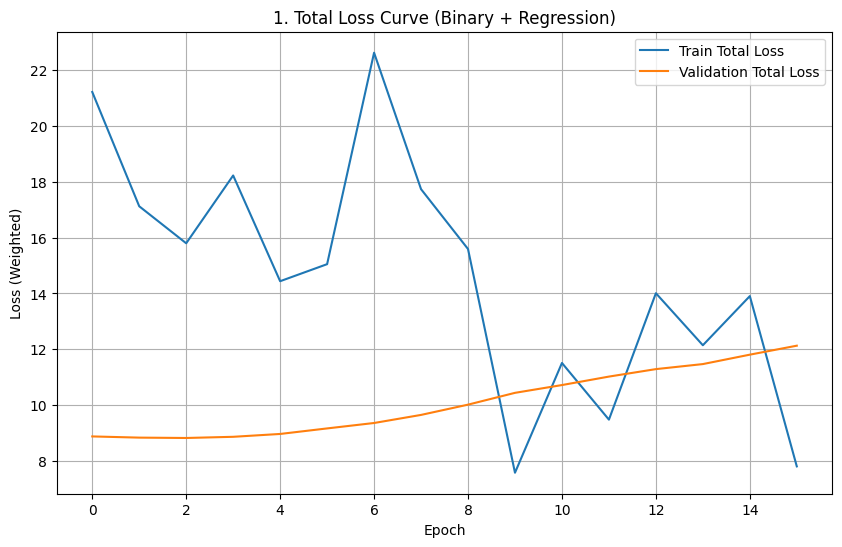

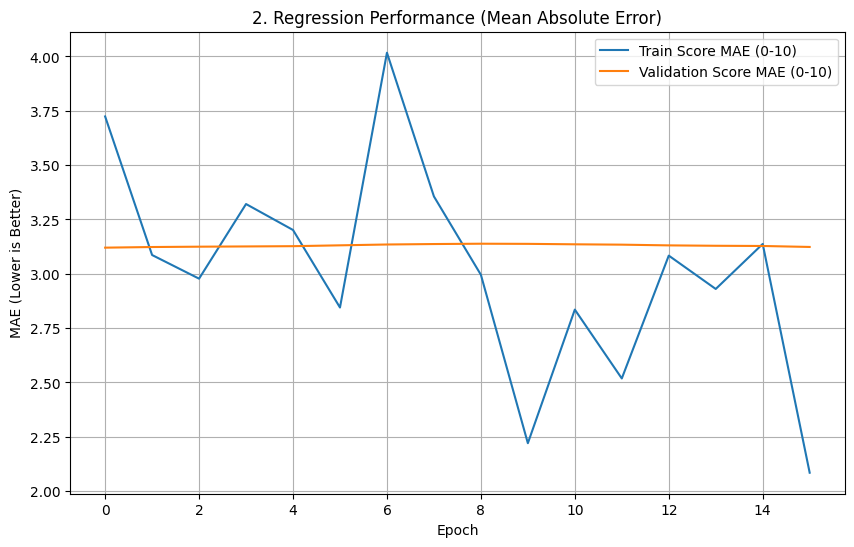

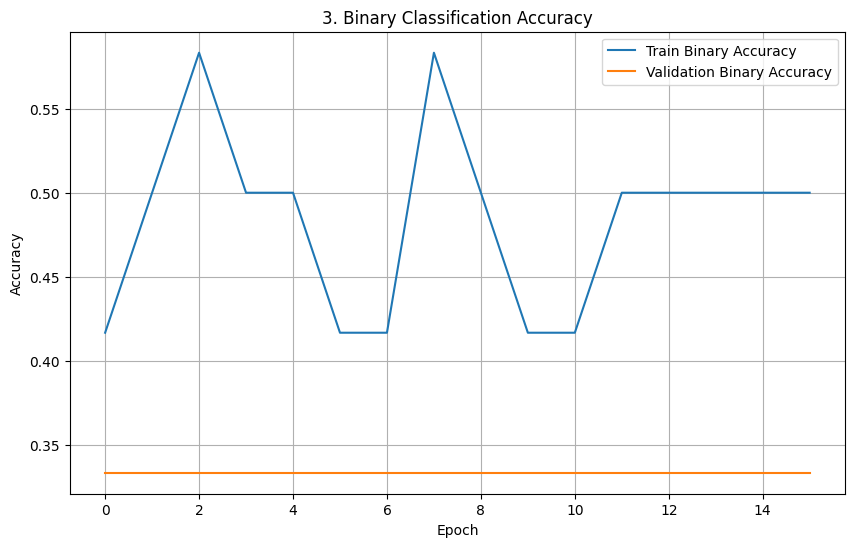

In [27]:
if 'history_mtl_reg' in locals():
    history = history_mtl_reg
    
    # 1. Total Loss Curve (Used for training the model)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['val_loss'], label='Validation Total Loss')
    plt.title('1. Total Loss Curve (Binary + Regression)')
    plt.ylabel('Loss (Weighted)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Regression Metric Curve (Mean Absolute Error on 0-10 Score)
    # The key metric for regression breakthrough.
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['score_output_mae'], label='Train Score MAE (0-10)')
    plt.plot(history.history['val_score_output_mae'], label='Validation Score MAE (0-10)')
    plt.title('2. Regression Performance (Mean Absolute Error)')
    plt.ylabel('MAE (Lower is Better)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. Binary Classification Accuracy (Sanity check)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['binary_output_accuracy'], label='Train Binary Accuracy')
    plt.plot(history.history['val_binary_output_accuracy'], label='Validation Binary Accuracy')
    plt.title('3. Binary Classification Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Hyperparameter Tuning

In [28]:
FIXED_LR = 1e-5 

tuning_grid = [
    # Run 1: Baseline Stable LR with minimal Dropout
    {'LR': FIXED_LR, 'W_Binary': 0.1, 'D_BERT': 0.5, 'D_FC': 0.3, 'NAME': 'BASE_STABLE'},
    
    # Run 2: Heavy Dropout to force generalization (best for N=12 overfitting)
    {'LR': FIXED_LR, 'W_Binary': 0.1, 'D_BERT': 0.7, 'D_FC': 0.5, 'NAME': 'HEAVY_REGULARIZATION'},
    
    # Run 3: Increase Binary Loss Weight (to enforce class separation)
    {'LR': FIXED_LR, 'W_Binary': 0.5, 'D_BERT': 0.5, 'D_FC': 0.3, 'NAME': 'WEIGHT_BINARY_UP'},
    
    # Run 4: Combined strongest regularization
    {'LR': FIXED_LR, 'W_Binary': 0.3, 'D_BERT': 0.6, 'D_FC': 0.4, 'NAME': 'OPTIMIZED_COMBO'},
]

In [29]:
tuning_results = []
best_val_mae = float('inf')
best_params = None
best_history = None

In [30]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from transformers import TFBertModel
from copy import deepcopy

def binary_focal_loss(gamma=2., alpha=0.25):
    """Focal Loss for handling binary class imbalance."""
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.math.pow((1 - p_t), gamma)
        loss = -alpha_factor * modulating_factor * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return focal_loss_fixed

def build_multi_task_bert_regression(max_len=128, bert_model_name='bert-base-uncased', dropout_bert=0.5, dropout_fc=0.3):
    """Multi-Task Regression BERT model with PEFT and tunable dropout."""
    tf.keras.backend.clear_session()
    
    input_ids      = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    bert = TFBertModel.from_pretrained(bert_model_name, from_pt=True) 
    bert.trainable = False # CRITICAL: Layer Freezing (PEFT)

    cls_token = bert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    
    # Shared layers with tunable dropout
    x = Dropout(dropout_bert, name='shared_dropout')(cls_token)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_fc)(x)

    # 1. Regression Head (0-10 Score)
    unscaled_output = Dense(1, activation='sigmoid')(x)
    score_output = Lambda(lambda z: z * 10.0, name='score_output')(unscaled_output)

    # 2. Binary Head (Regularization)
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=[binary_output, score_output])
    return model

In [31]:
for i, params in enumerate(tuning_grid):
    print(f"\n--- RUN {i+1}/{len(tuning_grid)}: {params['NAME']} ---")

    # 1. Build Model
    model = build_multi_task_bert_regression(
        dropout_bert=params['D_BERT'], 
        dropout_fc=params['D_FC']
    )

    # 2. Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['LR']),
        loss={
            'binary_output': binary_focal_loss(gamma=2., alpha=0.3),
            'score_output': MeanSquaredError(name='mse')
        },
        loss_weights={'binary_output': params['W_Binary'], 'score_output': 1.0},
        metrics={
            'binary_output': 'accuracy',
            'score_output': MeanAbsoluteError(name='mae')
        }
    )

    # 3. Define Early Stopping (Patience remains the primary control)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_score_output_mae', 
        mode='min',
        patience=15, 
        restore_best_weights=True
    )
    
    # 4. Train Model (Max Epochs is now controlled by patience)
    history = model.fit(
        x={'input_ids': X_train_ids, 'attention_mask': X_train_mask},
        y=y_train_mtl,
        validation_data=(
            {'input_ids': X_dev_ids, 'attention_mask': X_dev_mask},
            y_dev_mtl
        ),
        epochs=100, # Still use 100 max epochs, but ES will stop it early
        batch_size=2,
        callbacks=[es_callback],
        verbose=0 
    )

    # 5. Log Results
    min_val_mae = min(history.history['val_score_output_mae'])
    
    tuning_results.append({
        'Run': i + 1,
        'Name': params['NAME'],
        'LR': params['LR'],
        'W_Binary': params['W_Binary'],
        'D_BERT': params['D_BERT'],
        'D_FC': params['D_FC'],
        'Min_Val_MAE': min_val_mae
    })
    
    # Update Best Model Tracking
    if min_val_mae < best_val_mae:
        best_val_mae = min_val_mae
        best_params = params
        best_history = deepcopy(history.history) 
        print(f"--> NEW BEST MAE: {min_val_mae:.4f}")


--- RUN 1/4: BASE_STABLE ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

--> NEW BEST MAE: 3.0413

--- RUN 2/4: HEAVY_REGULARIZATION ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

--> NEW BEST MAE: 2.8423

--- RUN 3/4: WEIGHT_BINARY_UP ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

--> NEW BEST MAE: 2.7540

--- RUN 4/4: OPTIMIZED_COMBO ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

--> NEW BEST MAE: 2.6489


   Run                  Name       LR  W_Binary  D_BERT  D_FC  Min_Val_MAE
3    4       OPTIMIZED_COMBO  0.00001       0.3     0.6   0.4     2.648935
2    3      WEIGHT_BINARY_UP  0.00001       0.5     0.5   0.3     2.754023
1    2  HEAVY_REGULARIZATION  0.00001       0.1     0.7   0.5     2.842287
0    1           BASE_STABLE  0.00001       0.1     0.5   0.3     3.041270

BEST PARAMETERS FOUND:
Name: OPTIMIZED_COMBO
Learning Rate: 1e-05
Binary Loss Weight: 0.3
Dropout BERT: 0.6
Dropout FC: 0.4
Minimum Validation MAE: 2.6489


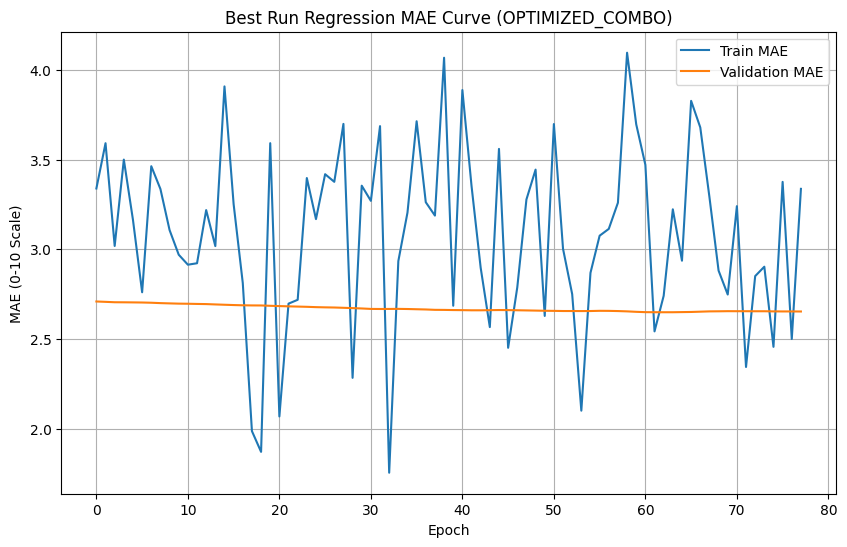

In [32]:
results_df = pd.DataFrame(tuning_results)
print(results_df.sort_values(by='Min_Val_MAE', ascending=True))

print(f"\nBEST PARAMETERS FOUND:")
if best_params:
    print(f"Name: {best_params['NAME']}")
    print(f"Learning Rate: {best_params['LR']}")
    print(f"Binary Loss Weight: {best_params['W_Binary']}")
    print(f"Dropout BERT: {best_params['D_BERT']}")
    print(f"Dropout FC: {best_params['D_FC']}")
    print(f"Minimum Validation MAE: {best_val_mae:.4f}")

    # Plotting the Learning Curve of the BEST RUN
    if best_history:
        plt.figure(figsize=(10, 6))
        plt.plot(best_history['score_output_mae'], label='Train MAE')
        plt.plot(best_history['val_score_output_mae'], label='Validation MAE')
        plt.title(f"Best Run Regression MAE Curve ({best_params['NAME']})")
        plt.ylabel('MAE (0-10 Scale)')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()


Rebuilding final model using Best Run parameters (LR: 1e-05, Binary Weight: 0.3).


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

1/1 [==============================] - 13s 13s/step
                   precision    recall  f1-score   support

Non-Depressed (0)       0.00      0.00      0.00         1
    Depressed (1)       0.67      1.00      0.80         2

         accuracy                           0.67         3
        macro avg       0.33      0.50      0.40         3
     weighted avg       0.44      0.67      0.53         3



C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\himan\anaconda3\envs\bert-tf\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


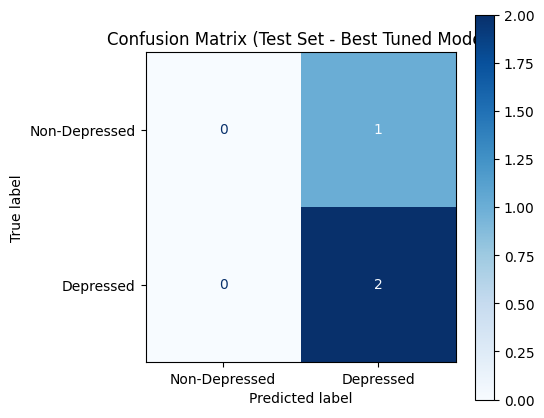


PRIMARY RESULT: Final Test MAE (0-10 Scale): 1.636


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
if not best_params:
    print("Error: Hyperparameter tuning did not run or 'best_params' is empty. Cannot proceed.")
else:
    # Use the best parameters found
    BEST_LR = best_params['LR']
    BEST_W_BINARY = best_params['W_Binary']
    BEST_D_BERT = best_params['D_BERT']
    BEST_D_FC = best_params['D_FC']

    print(f"\nRebuilding final model using Best Run parameters (LR: {BEST_LR}, Binary Weight: {BEST_W_BINARY}).")
    final_model = build_multi_task_bert_regression(
        dropout_bert=BEST_D_BERT, 
        dropout_fc=BEST_D_FC
    )

    final_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_LR),
        loss={
            'binary_output': binary_focal_loss(gamma=2., alpha=0.3),
            'score_output': MeanSquaredError(name='mse')
        },
        loss_weights={'binary_output': BEST_W_BINARY, 'score_output': 1.0},
        metrics={
            'binary_output': 'accuracy',
            'score_output': MeanAbsoluteError(name='mae')
        }
    )
    
    y_pred_bin, y_pred_score_0_10 = final_model.predict(
        {'input_ids': X_test_ids, 'attention_mask': X_test_mask}
    )
    y_test_bin_true = y_binary[test_mask]
    y_test_bin_pred = (y_pred_bin > 0.5).astype(int).flatten()

    
    # Classification Report
    print(classification_report(y_test_bin_true, y_test_bin_pred, target_names=['Non-Depressed (0)', 'Depressed (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_bin_true, y_test_bin_pred)
    
    plt.figure(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Depressed', 'Depressed'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix (Test Set - Best Tuned Model)')
    plt.show()
    y_test_score_true = y_regression_target_0_10[test_mask]
    y_test_score_pred = y_pred_score_0_10.flatten()
    mae = mean_absolute_error(y_test_score_true, y_test_score_pred)
    
    print(f"\nPRIMARY RESULT: Final Test MAE (0-10 Scale): {mae:.3f}")

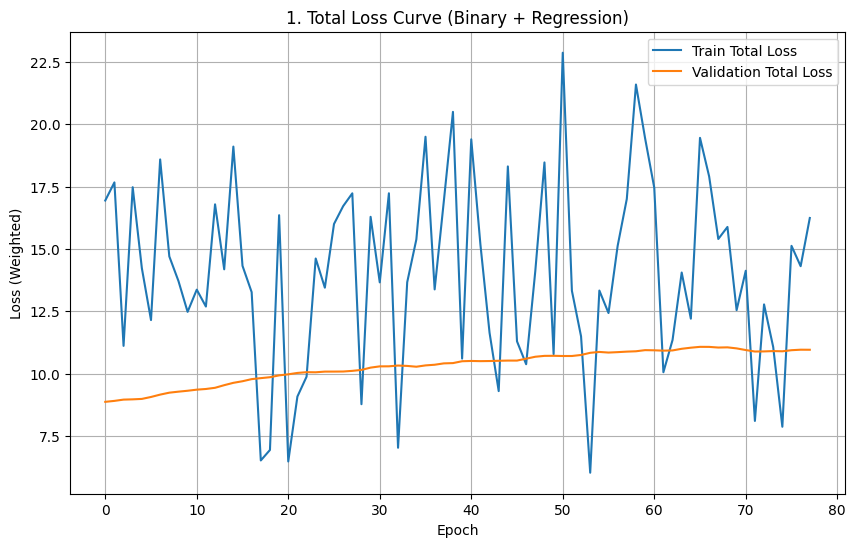

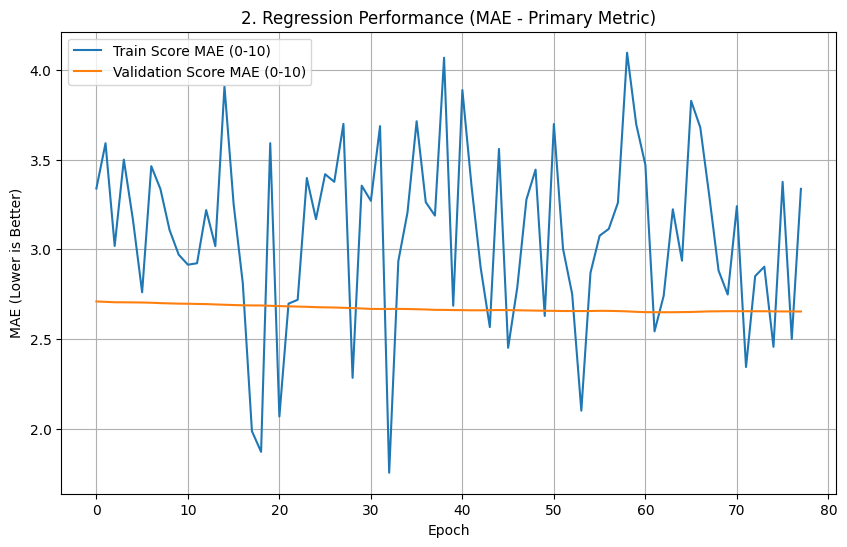

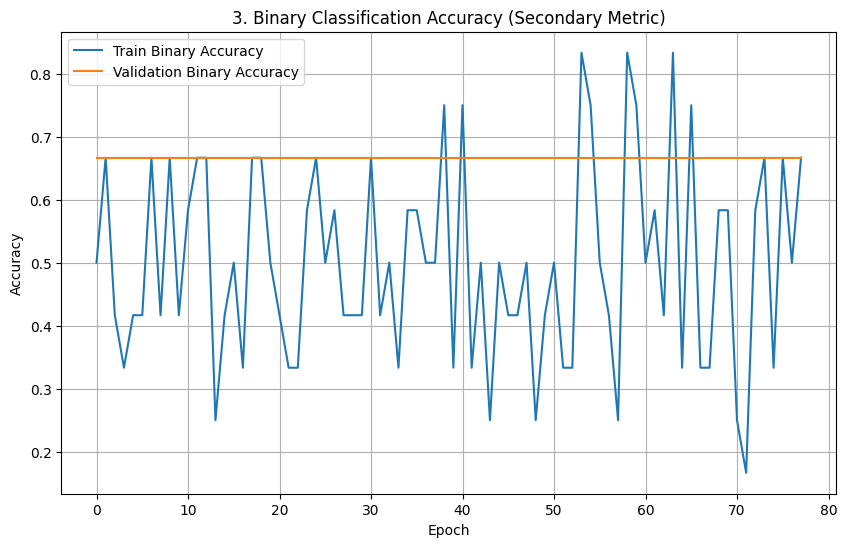

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'best_history' in locals():
    history = best_history
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Total Loss')
    plt.plot(history['val_loss'], label='Validation Total Loss')
    plt.title('1. Total Loss Curve (Binary + Regression)')
    plt.ylabel('Loss (Weighted)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(history['score_output_mae'], label='Train Score MAE (0-10)')
    plt.plot(history['val_score_output_mae'], label='Validation Score MAE (0-10)')
    plt.title('2. Regression Performance (MAE - Primary Metric)')
    plt.ylabel('MAE (Lower is Better)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(history['binary_output_accuracy'], label='Train Binary Accuracy')
    plt.plot(history['val_binary_output_accuracy'], label='Validation Binary Accuracy')
    plt.title('3. Binary Classification Accuracy (Secondary Metric)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Error: The 'best_history' object was not found. Please ensure the hyperparameter tuning loop was executed successfully before running this visualization block.")